In [43]:
import pandas as pd
import gender_guesser.detector as gd
from genderize import Genderize
from tqdm import tqdm
import swifter 
import seaborn as sns
import matplotlib.pyplot as plt

detector = gd.Detector()

In [26]:
df = pd.read_csv('MED_Crossreff_pull_100.csv')

In [27]:
print(df.shape)
df.head()

(1064632, 12)


,DOI,Title,Container Title,Publisher,Publish Date,Author First Name,Author Last Name,Author Order,Referenced By,Year,Subject,Topic
0,10.1053/j.gastro.2017.01.048,Transforming Gastroenterology Care With Teleme...,Gastroenterology,Elsevier BV,"[2017, 4]",Corey A.,Siegel,1,52,2017,Gastroenterology,Medical & Health
1,10.1016/s0016-5085(17)31057-0,The Gastroenterology Fellowship Match: A Decad...,Gastroenterology,Elsevier BV,"[2017, 4]",Robert J.,Huang,1,0,2017,Gastroenterology,Medical & Health
2,10.1016/s0016-5085(17)31057-0,The Gastroenterology Fellowship Match: A Decad...,Gastroenterology,Elsevier BV,"[2017, 4]",David,Limsui,2,0,2017,Gastroenterology,Medical & Health
3,10.1053/j.gastro.2017.08.001,Reply,Gastroenterology,Elsevier BV,"[2017, 9]",Edward,Gane,1,0,2017,Gastroenterology,Medical & Health
4,10.1053/j.gastro.2017.05.008,Reply,Gastroenterology,Elsevier BV,"[2017, 6]",Yoshiaki,Ito,1,0,2017,Gastroenterology,Medical & Health


In [33]:
import swifter
import gender_guesser.detector as gg

detector = gg.Detector()

def predict_gender(name):
    # Check if name is a string and is not empty
    if not isinstance(name, str) or not name.strip():
        return "X"

    # Extract first name from the string
    names_split = name.split()
    if not names_split:
        return "X"
    
    first_name = names_split[0]

    # Using gender_guesser
    gg_guess = detector.get_gender(first_name)

    # Convert gender_guesser's response to M, F, or X
    if gg_guess in ["male", "mostly_male"]:
        return "M"
    elif gg_guess in ["female", "mostly_female"]:
        return "F"
    else:
        return "X"


# Assuming df is your DataFrame with the column 'Author First Name'
df_result = df.copy()  # Create a copy of the original DataFrame

# Using swifter's apply method to utilize all CPU cores
df_result['Gender'] = df['Author First Name'].swifter.apply(predict_gender)

Pandas Apply: 100%|██████████| 1064632/1064632 [00:01<00:00, 587984.37it/s]


In [34]:
df_result.head()

,DOI,Title,Container Title,Publisher,Publish Date,Author First Name,Author Last Name,Author Order,Referenced By,Year,Subject,Topic,Gender
0,10.1053/j.gastro.2017.01.048,Transforming Gastroenterology Care With Teleme...,Gastroenterology,Elsevier BV,"[2017, 4]",Corey A.,Siegel,1,52,2017,Gastroenterology,Medical & Health,M
1,10.1016/s0016-5085(17)31057-0,The Gastroenterology Fellowship Match: A Decad...,Gastroenterology,Elsevier BV,"[2017, 4]",Robert J.,Huang,1,0,2017,Gastroenterology,Medical & Health,M
2,10.1016/s0016-5085(17)31057-0,The Gastroenterology Fellowship Match: A Decad...,Gastroenterology,Elsevier BV,"[2017, 4]",David,Limsui,2,0,2017,Gastroenterology,Medical & Health,M
3,10.1053/j.gastro.2017.08.001,Reply,Gastroenterology,Elsevier BV,"[2017, 9]",Edward,Gane,1,0,2017,Gastroenterology,Medical & Health,M
4,10.1053/j.gastro.2017.05.008,Reply,Gastroenterology,Elsevier BV,"[2017, 6]",Yoshiaki,Ito,1,0,2017,Gastroenterology,Medical & Health,M


In [35]:
# Identify articles with missing author names
missing_author_article_ids = df_result[df_result['Author First Name'].isna() | (df_result['Author First Name'].astype(str).str.strip() == '')]['Title'].unique()

# Filter out those articles
df_result = df_result[~df_result['Title'].isin(missing_author_article_ids)]


In [46]:
gender_counts = df_result['Gender'].value_counts()
gender_percentage = df_result['Gender'].value_counts(normalize=True) * 100

for gender, count in gender_counts.items():
    print(f"{gender}: {count} ({gender_percentage[gender]:.2f}%)")


M: 333345 (40.21%)
X: 324420 (39.13%)
F: 171238 (20.66%)


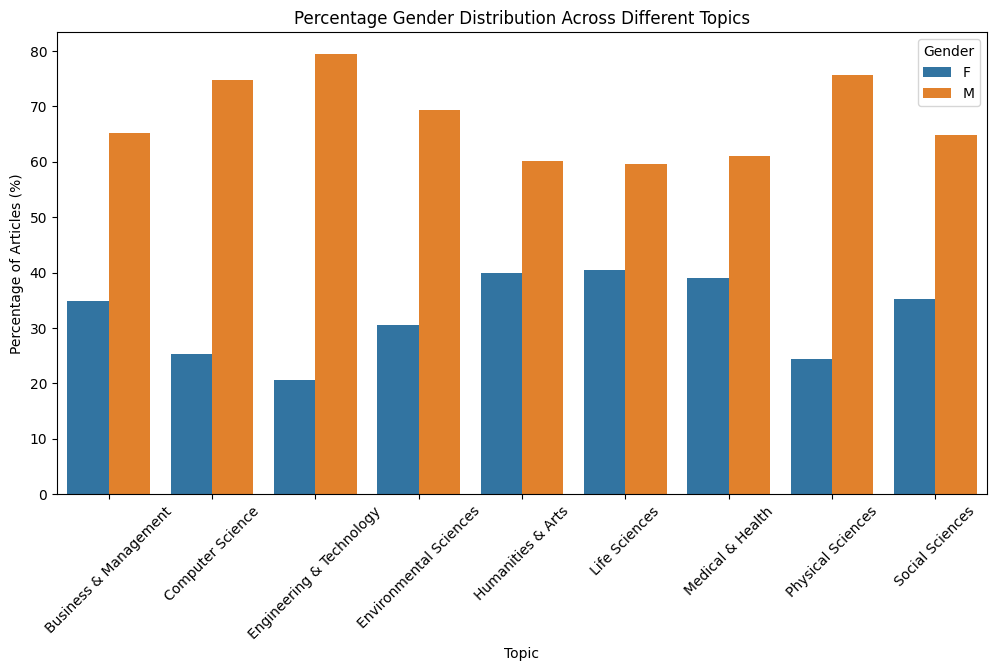

In [47]:
# Filter out rows with Topic as 'Other' and Gender as 'X'
filtered_df = df_result[(df_result['Topic'] != 'Others') & (df_result['Gender'] != 'X')]

# Compute the percentage distribution
topic_gender_distribution = filtered_df.groupby(['Topic', 'Gender']).size().unstack().fillna(0)
topic_gender_distribution_percentage = topic_gender_distribution.divide(topic_gender_distribution.sum(axis=1), axis=0) * 100

topic_gender_distribution_percentage.reset_index(inplace=True)
topic_gender_distribution_percentage = topic_gender_distribution_percentage.melt(id_vars='Topic', value_name='Percentage')

plt.figure(figsize=(12, 6))
sns.barplot(data=topic_gender_distribution_percentage, x='Topic', y='Percentage', hue='Gender')
plt.title('Percentage Gender Distribution Across Different Topics')
plt.xlabel('Topic')
plt.ylabel('Percentage of Articles (%)')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()


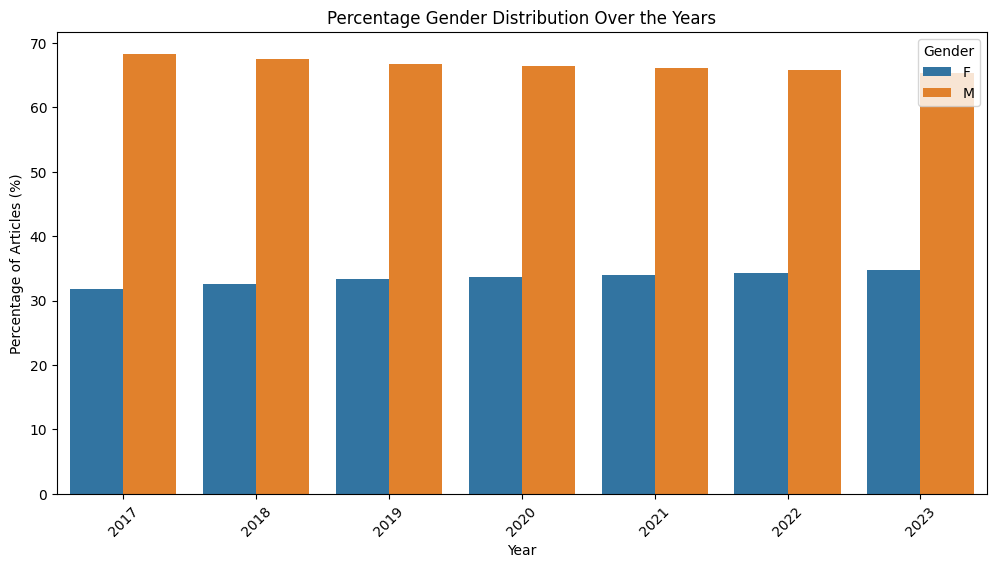

In [45]:
# Filter out rows with Gender as 'X'
filtered_df_year = df_result[df_result['Gender'] != 'X']

# Compute the percentage distribution
year_gender_distribution = filtered_df_year.groupby(['Year', 'Gender']).size().unstack().fillna(0)
year_gender_distribution_percentage = year_gender_distribution.divide(year_gender_distribution.sum(axis=1), axis=0) * 100

year_gender_distribution_percentage.reset_index(inplace=True)
year_gender_distribution_percentage = year_gender_distribution_percentage.melt(id_vars='Year', value_name='Percentage')

plt.figure(figsize=(12, 6))
sns.barplot(data=year_gender_distribution_percentage, x='Year', y='Percentage', hue='Gender')
plt.title('Percentage Gender Distribution Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage of Articles (%)')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()


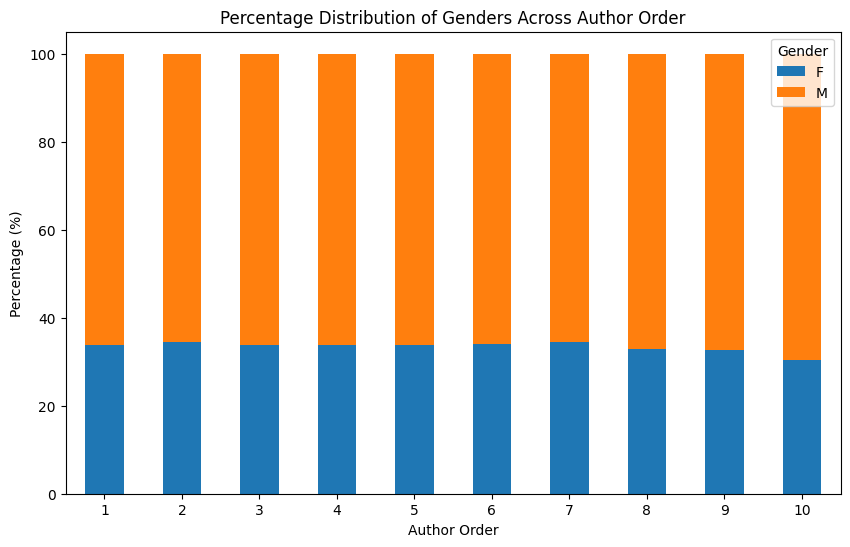

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for relevant genders and orders
filtered_df = df_result[(df_result['Gender'].isin(['M', 'F'])) & (df_result['Author Order'] <= 10)]

# Cross-tabulate to find counts of each gender for each author position
ctab = pd.crosstab(index=filtered_df['Author Order'], columns=filtered_df['Gender'], normalize='index') * 100

# Plot the result
ctab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Percentage Distribution of Genders Across Author Order')
plt.ylabel('Percentage (%)')
plt.xlabel('Author Order')
plt.legend(title='Gender')
plt.xticks(rotation=0)  # Set the rotation for x-axis labels
plt.show()
